In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the dataset (replace 'your_data.csv' with your actual file path)
df = pd.read_csv('IGI.csv')

# Ensure the 'timestamp' column is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Feature engineering (example features: glucose levels, time of day, etc.)
df['hour'] = df['timestamp'].dt.hour
df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)

# Features (X) and target (y)
X = df[['Glucose_old', 'Glucose_new', 'sin_hour', 'cos_hour']].values
y = df['Insulin'].values

# Split the data into training and testing sets (assuming patient ID column exists)
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(X, y, df.index, test_size=0.2, random_state=42)

# Store first 10 patients' IDs (assuming 'id' column exists)
first_10_patients_ids = df['id'].unique()[:10]


In [2]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense

# Function to compute Adjusted R²
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Initialize result storage for all metrics
results_detailed = {'Algorithm': [], 'RMSE': [], 'MAE': [], 'R²': [], 'Adjusted R²': [],
                    'P-value': [], 't-statistic': [], 'F-statistic': [], 'Durbin-Watson': [],
                    'AIC': [], 'BIC': []}

# --- 1. Train Linear Regression Model ---
X_train_with_const = sm.add_constant(X_train)
X_test_with_const = sm.add_constant(X_test)

# Fit the Linear Regression model using statsmodels (OLS)
ols_model = sm.OLS(y_train, X_train_with_const).fit()
ols_pred = ols_model.predict(X_test_with_const)

# Compute metrics for Linear Regression
ols_rmse = np.sqrt(mean_squared_error(y_test, ols_pred))
ols_mae = mean_absolute_error(y_test, ols_pred)
ols_r2 = r2_score(y_test, ols_pred)
ols_adjusted_r2 = adjusted_r2(ols_r2, len(y_test), X_test.shape[1])

# Extract stats from the OLS summary
ols_summary = ols_model.summary2().tables[1]
ols_pvalues = ols_summary['P>|t|'].values
ols_tstat = ols_summary['t'].values
ols_fstat = ols_model.fvalue
ols_durbin_watson = sm.stats.durbin_watson(ols_model.resid)
ols_aic = ols_model.aic
ols_bic = ols_model.bic

# Store results for Linear Regression
results_detailed['Algorithm'].append('OLS Linear Regression')
results_detailed['RMSE'].append(ols_rmse)
results_detailed['MAE'].append(ols_mae)
results_detailed['R²'].append(ols_r2)
results_detailed['Adjusted R²'].append(ols_adjusted_r2)
results_detailed['P-value'].append(ols_pvalues)
results_detailed['t-statistic'].append(ols_tstat)
results_detailed['F-statistic'].append(ols_fstat)
results_detailed['Durbin-Watson'].append(ols_durbin_watson)
results_detailed['AIC'].append(ols_aic)
results_detailed['BIC'].append(ols_bic)

# --- 2. PCA + Linear Regression ---
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Fit PCA + Linear Regression using OLS from statsmodels
X_train_pca_with_const = sm.add_constant(X_train_pca)
X_test_pca_with_const = sm.add_constant(X_test_pca)

pca_ols_model = sm.OLS(y_train, X_train_pca_with_const).fit()
pca_ols_pred = pca_ols_model.predict(X_test_pca_with_const)

# Compute metrics for PCA + Linear Regression
pca_ols_rmse = np.sqrt(mean_squared_error(y_test, pca_ols_pred))
pca_ols_mae = mean_absolute_error(y_test, pca_ols_pred)
pca_ols_r2 = r2_score(y_test, pca_ols_pred)
pca_ols_adjusted_r2 = adjusted_r2(pca_ols_r2, len(y_test), X_test_pca.shape[1])

# Extract stats from the OLS summary
pca_ols_summary = pca_ols_model.summary2().tables[1]
pca_ols_pvalues = pca_ols_summary['P>|t|'].values
pca_ols_tstat = pca_ols_summary['t'].values
pca_ols_fstat = pca_ols_model.fvalue
pca_ols_durbin_watson = sm.stats.durbin_watson(pca_ols_model.resid)
pca_ols_aic = pca_ols_model.aic
pca_ols_bic = pca_ols_model.bic

# Store results for PCA + Linear Regression
results_detailed['Algorithm'].append('PCA + Linear Regression')
results_detailed['RMSE'].append(pca_ols_rmse)
results_detailed['MAE'].append(pca_ols_mae)
results_detailed['R²'].append(pca_ols_r2)
results_detailed['Adjusted R²'].append(pca_ols_adjusted_r2)
results_detailed['P-value'].append(pca_ols_pvalues)
results_detailed['t-statistic'].append(pca_ols_tstat)
results_detailed['F-statistic'].append(pca_ols_fstat)
results_detailed['Durbin-Watson'].append(pca_ols_durbin_watson)
results_detailed['AIC'].append(pca_ols_aic)
results_detailed['BIC'].append(pca_ols_bic)

# --- 3. Train Random Forest Model ---
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# Compute metrics for Random Forest
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)
rf_adjusted_r2 = adjusted_r2(rf_r2, len(y_test), X_test.shape[1])

# Store results for Random Forest
results_detailed['Algorithm'].append('Random Forest')
results_detailed['RMSE'].append(rf_rmse)
results_detailed['MAE'].append(rf_mae)
results_detailed['R²'].append(rf_r2)
results_detailed['Adjusted R²'].append(rf_adjusted_r2)
results_detailed['P-value'].append('N/A')
results_detailed['t-statistic'].append('N/A')
results_detailed['F-statistic'].append('N/A')
results_detailed['Durbin-Watson'].append('N/A')
results_detailed['AIC'].append('N/A')
results_detailed['BIC'].append('N/A')

# --- 4. Train Deep Neural Network (DNN) ---
# Build DNN model
dnn_model = Sequential()
dnn_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
dnn_model.add(Dense(64, activation='relu'))
dnn_model.add(Dense(1, activation='linear'))
dnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the DNN
dnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
dnn_pred = dnn_model.predict(X_test).flatten()

# Compute metrics for DNN
dnn_rmse = np.sqrt(mean_squared_error(y_test, dnn_pred))
dnn_mae = mean_absolute_error(y_test, dnn_pred)
dnn_r2 = r2_score(y_test, dnn_pred)
dnn_adjusted_r2 = adjusted_r2(dnn_r2, len(y_test), X_test.shape[1])

# Store results for DNN
results_detailed['Algorithm'].append('Deep Neural Network')
results_detailed['RMSE'].append(dnn_rmse)
results_detailed['MAE'].append(dnn_mae)
results_detailed['R²'].append(dnn_r2)
results_detailed['Adjusted R²'].append(dnn_adjusted_r2)
results_detailed['P-value'].append('N/A')
results_detailed['t-statistic'].append('N/A')
results_detailed['F-statistic'].append('N/A')
results_detailed['Durbin-Watson'].append('N/A')
results_detailed['AIC'].append('N/A')
results_detailed['BIC'].append('N/A')

# Convert results to a DataFrame and display
results_detailed_df = pd.DataFrame(results_detailed)
print(results_detailed_df)

# Save to a text file
results_detailed_df.to_csv('detailed_results.txt', sep='\t', index=False)
print("Detailed results saved to 'detailed_results.txt'.")


2024-09-15 21:43:40.431973: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-15 21:43:41.646591: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/50


/home/orion/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-15 21:43:57.223861: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-15 21:43:57.348812: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the req

2444/2444 ━━━━━━━━━━━━━━━━━━━━ 2s 590us/step - loss: 447.3851 - mae: 8.1552 - val_loss: 655.4504 - val_mae: 7.4435
Epoch 2/50
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 1s 554us/step - loss: 524.0996 - mae: 8.2038 - val_loss: 653.2645 - val_mae: 8.2058
Epoch 3/50
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 1s 561us/step - loss: 545.1160 - mae: 8.1391 - val_loss: 652.5164 - val_mae: 7.9060
Epoch 4/50
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 1s 567us/step - loss: 494.4307 - mae: 8.0906 - val_loss: 657.2610 - val_mae: 9.0077
Epoch 5/50
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 1s 555us/step - loss: 560.8256 - mae: 8.1960 - val_loss: 652.8166 - val_mae: 7.7508
Epoch 6/50
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 1s 561us/step - loss: 476.4360 - mae: 7.9332 - val_loss: 653.0629 - val_mae: 8.2895
Epoch 7/50
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 1s 545us/step - loss: 512.0073 - mae: 8.1141 - val_loss: 653.9885 - val_mae: 8.5378
Epoch 8/50
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 1s 546us/step - loss: 571.1119 - mae: 8.2132 - val_loss: 653.2665 - val_mae: 7.8008
Epo

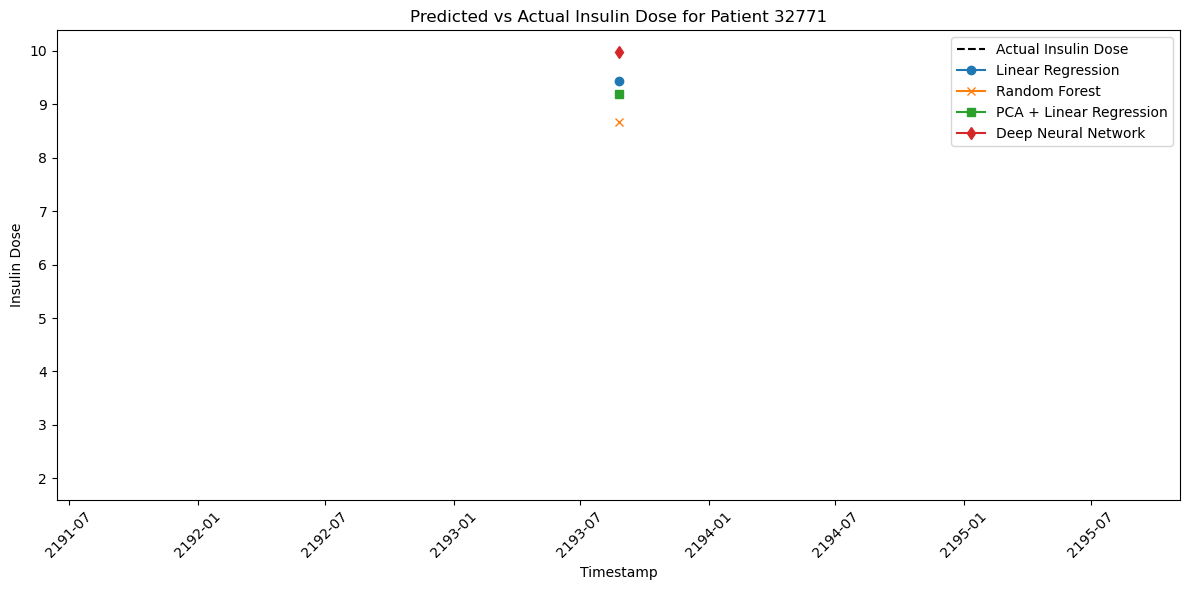

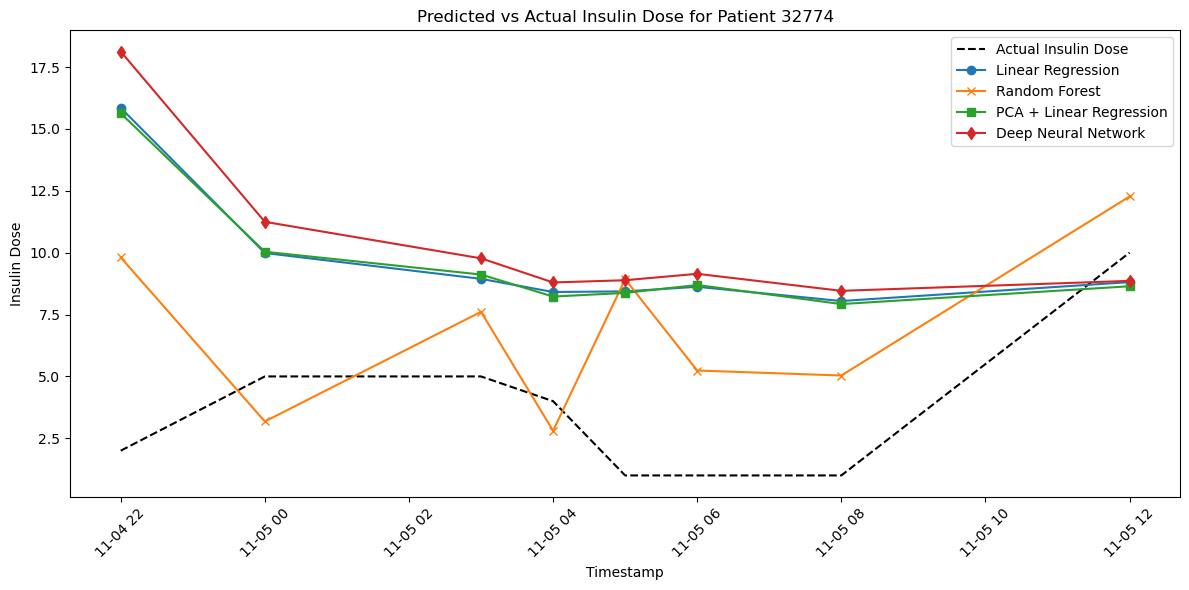

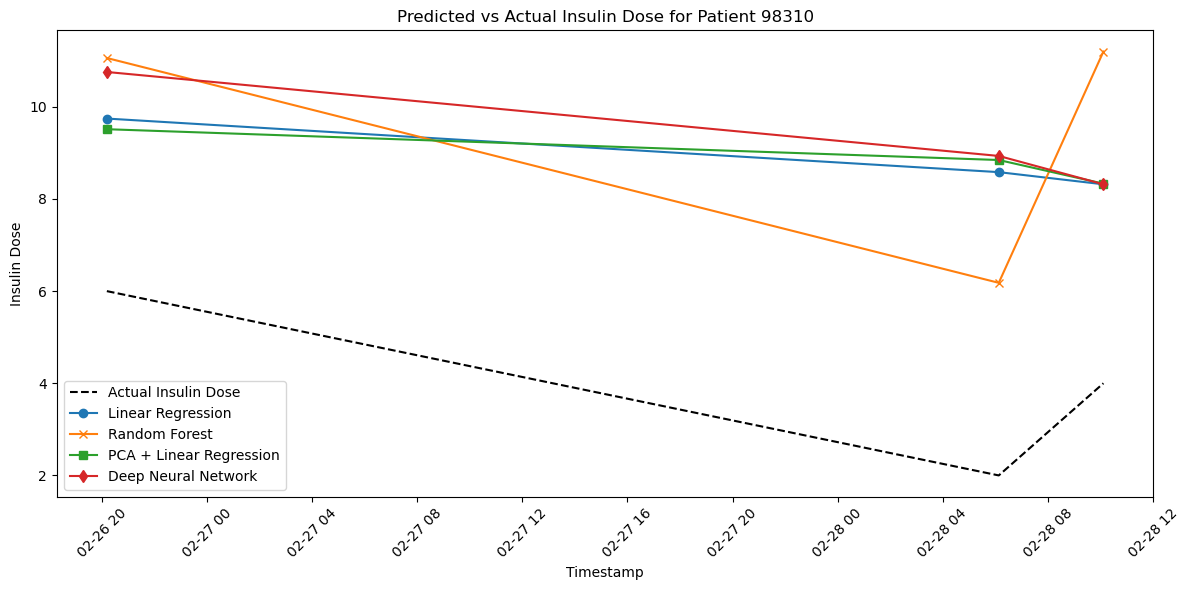

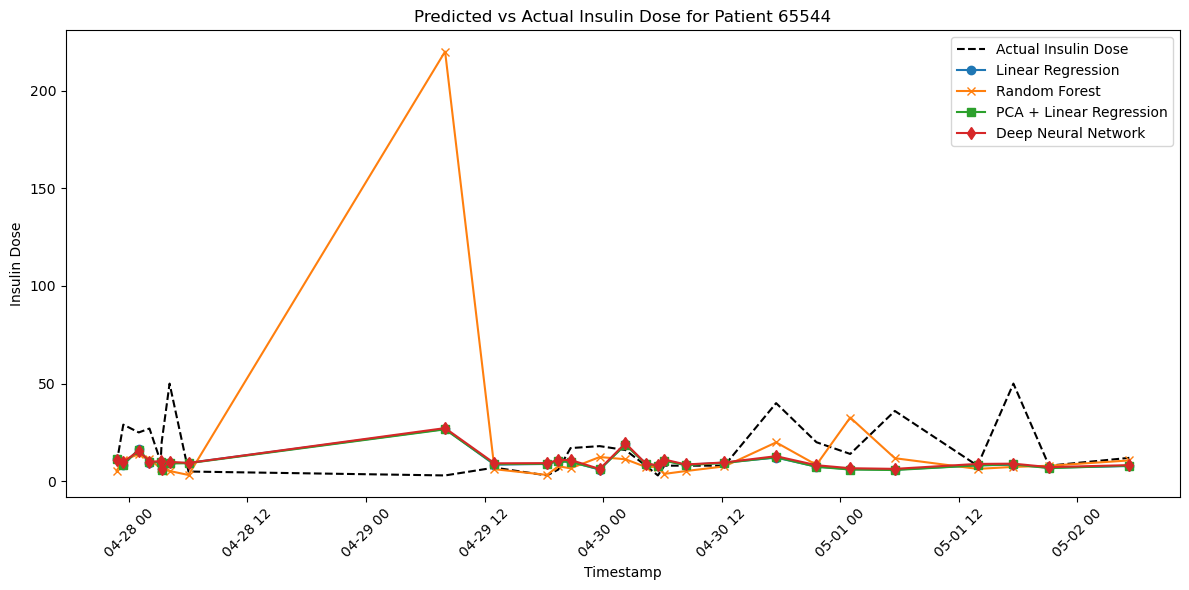

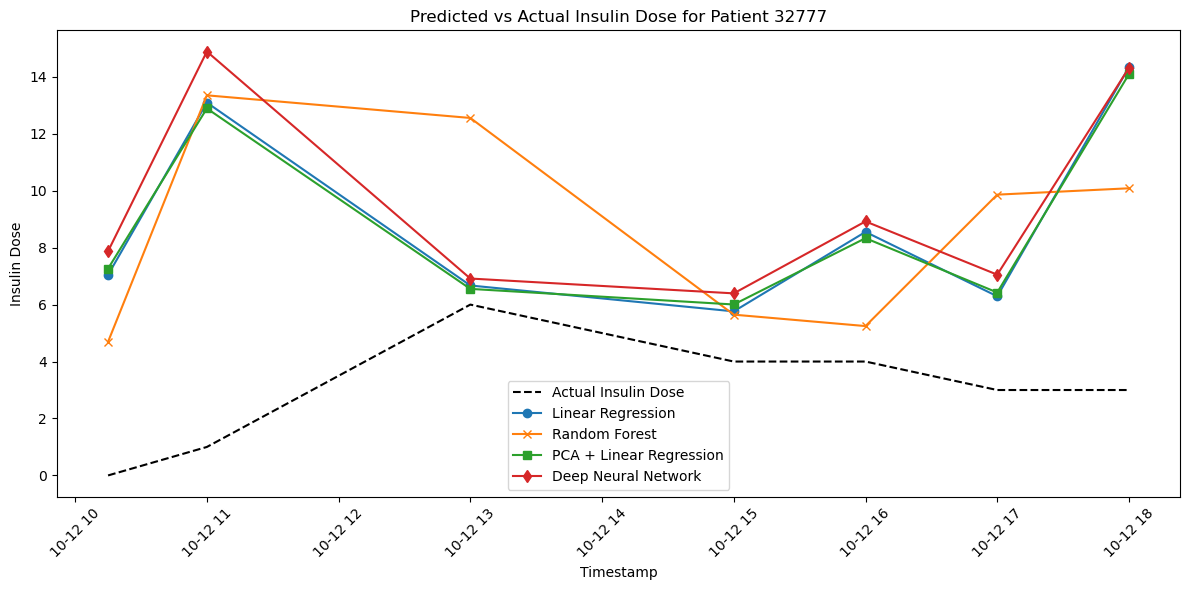

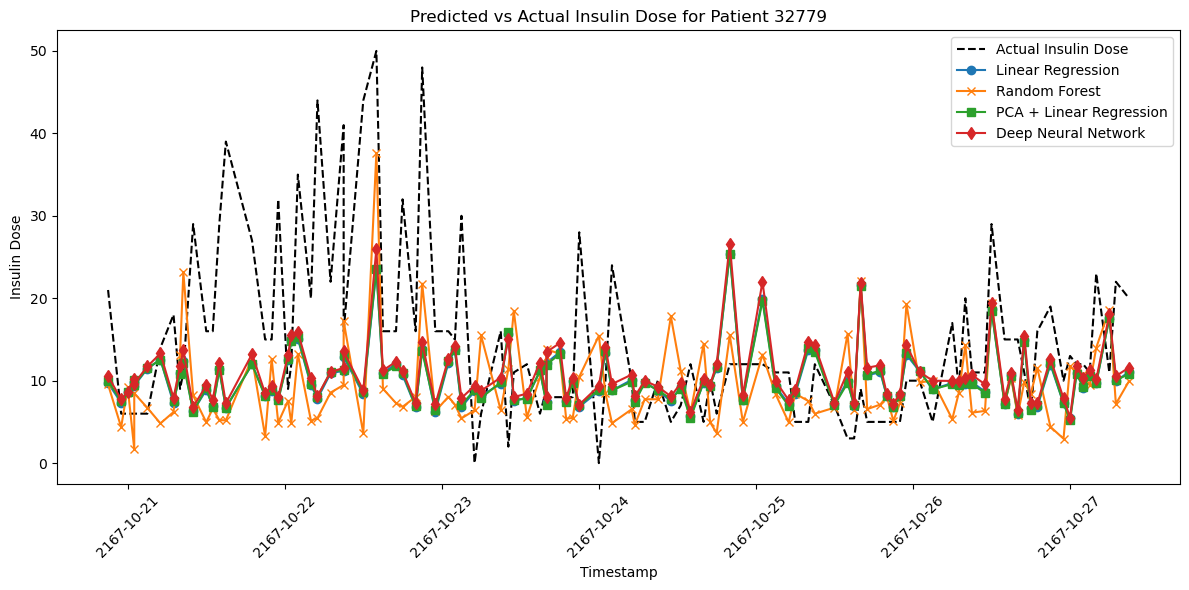

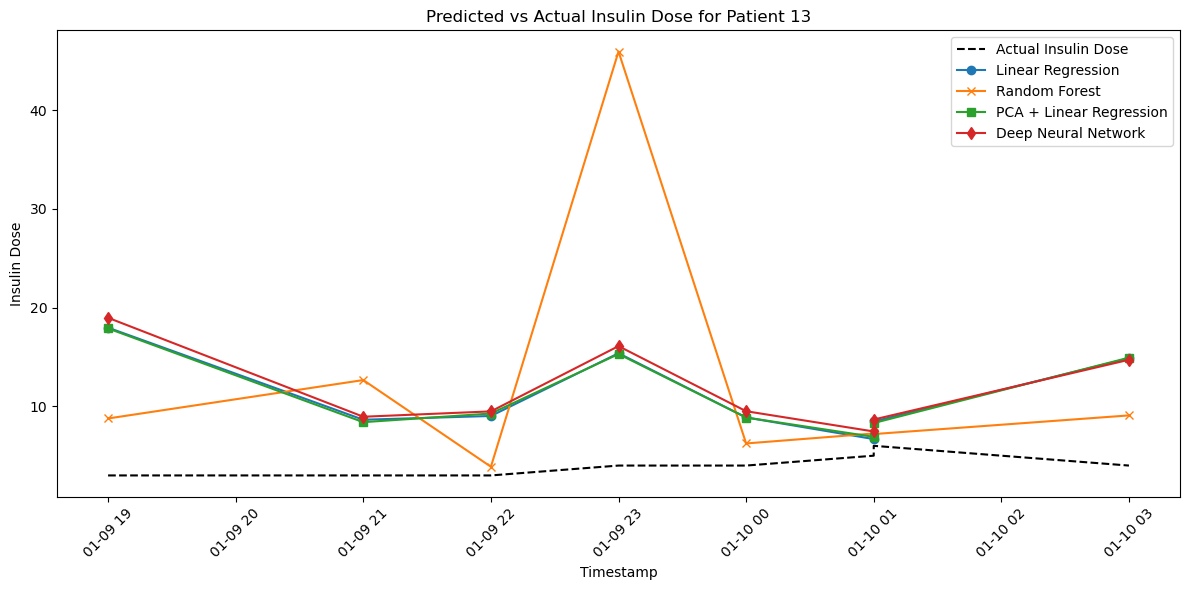

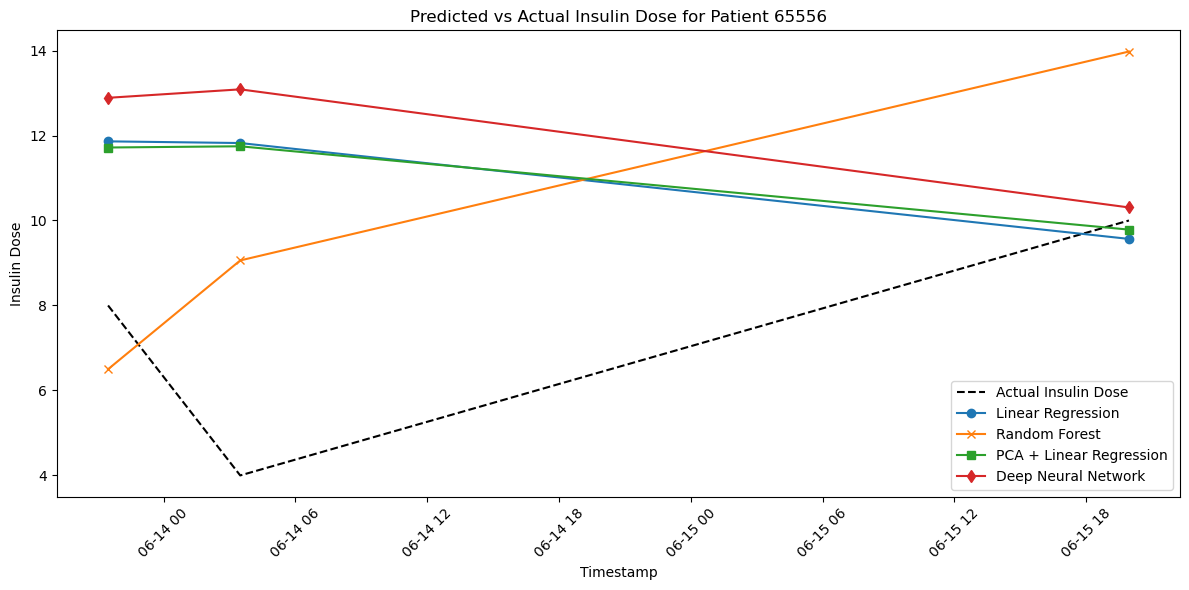

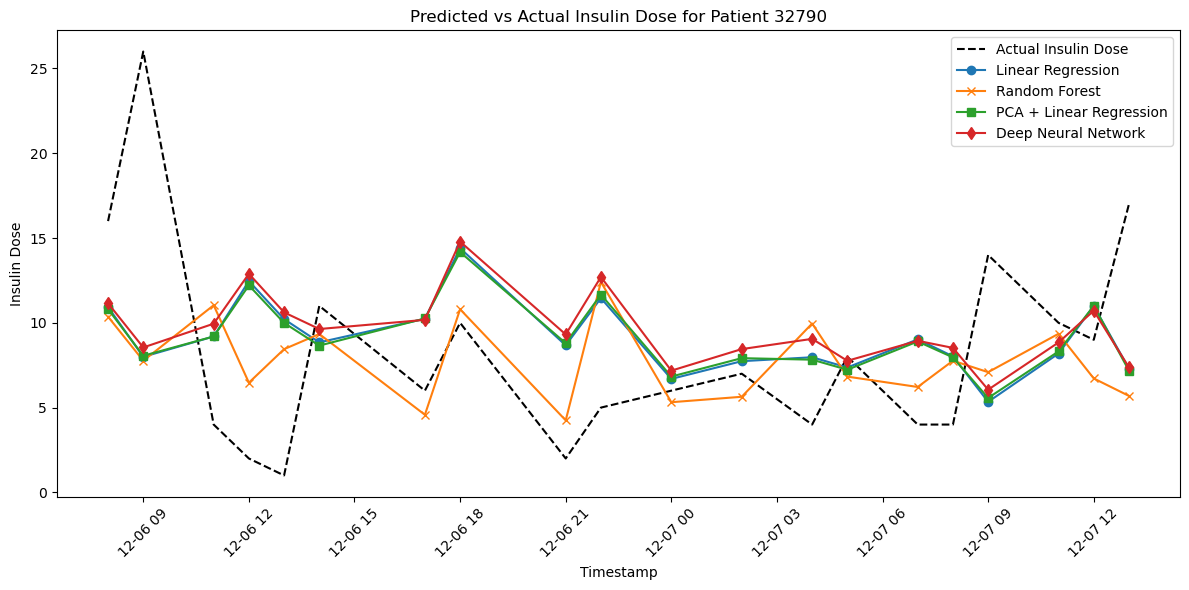

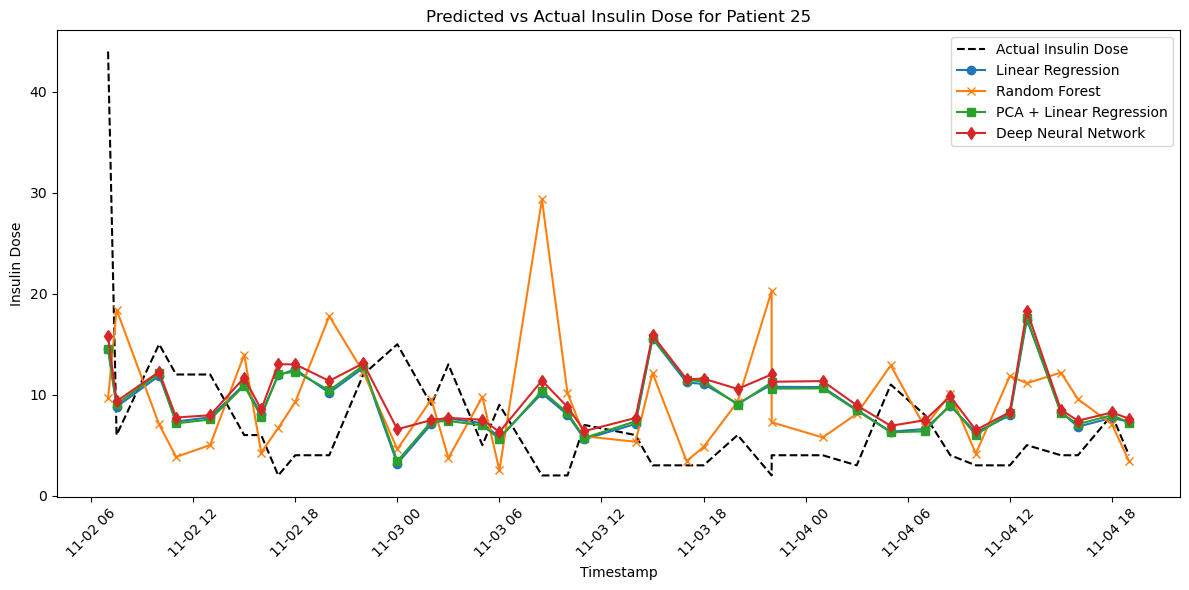

In [3]:
import matplotlib.pyplot as plt

# Loop over each patient and generate a separate plot
for patient_id in first_10_patients_ids:
    # Filter the data for the current patient
    patient_data = df[df['id'] == patient_id]
    
    # Ensure the corresponding predicted values are for the current patient
    patient_index = patient_data.index
    actual_dose = patient_data['Insulin']
    
    # Predictions for the current patient
    lr_pred_patient = ols_pred[patient_index]
    rf_pred_patient = rf_pred[patient_index]
    pca_lr_pred_patient = pca_ols_pred[patient_index]
    dnn_pred_patient = dnn_pred[patient_index]

    # Plot the actual insulin dose vs predicted doses from each model
    plt.figure(figsize=(12, 6))

    # Plot actual insulin dose
    plt.plot(patient_data['timestamp'], actual_dose, label='Actual Insulin Dose', color='black', linestyle='--')

    # Plot predicted values from each model
    plt.plot(patient_data['timestamp'], lr_pred_patient, label='Linear Regression', marker='o')
    plt.plot(patient_data['timestamp'], rf_pred_patient, label='Random Forest', marker='x')
    plt.plot(patient_data['timestamp'], pca_lr_pred_patient, label='PCA + Linear Regression', marker='s')
    plt.plot(patient_data['timestamp'], dnn_pred_patient, label='Deep Neural Network', marker='d')

    # Customize the plot
    plt.xlabel('Timestamp')
    plt.ylabel('Insulin Dose')
    plt.title(f'Predicted vs Actual Insulin Dose for Patient {patient_id}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Show the plot for the current patient
    plt.show()
